In [115]:
!pip install timm

In [116]:
import torchvision
import torch
from torch import nn
import cv2
import numpy as np
import timm
import urllib
import matplotlib.pyplot as plt

In [117]:
def url_to_image(url,size=(600, 600)):
    resp = urllib.request.urlopen(url)
    img = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    
    return img

def read_img(img_path, size=(600, 600)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = torch.tensor(img, dtype=torch.float).permute(2,0,1)
    return img.unsqueeze(0)

imgs = [url_to_image('http://image.vietnamnews.vn/uploadvnnews/Storage/Images/2015/10/7/21a.jpg'), 
        url_to_image('https://media-cdn.tripadvisor.com/media/photo-s/15/26/b8/f3/generala-drapsina-street.jpg')]

img_tensor = torch.stack([torch.tensor(im, dtype=torch.float) for im in imgs])
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.shape # B x C x H x W

torch.Size([2, 3, 600, 600])

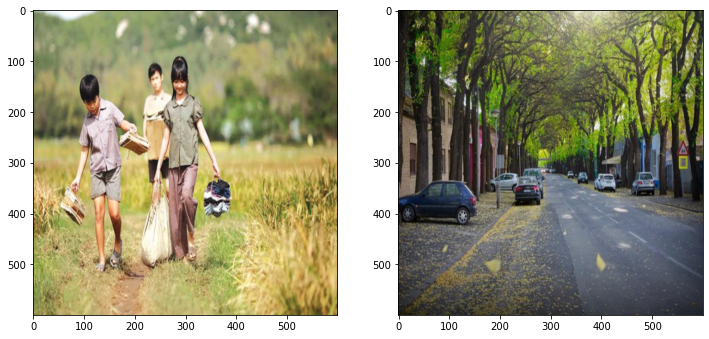

In [118]:
_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for im, ax in zip(imgs, axs):
    ax.imshow(im)
plt.show()

In [119]:
model_detection = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_emb = timm.create_model('efficientnet_b4', pretrained=True)

In [120]:
def process_bbox(detected, iou_thresh=0.5, score_thresh=0.5):
    '''
        Perform nms and remove low confidence boxes
        Args:
            detected: Dictionary for boxes detected in an image
                boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, 
                    with ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
                labels (Int64Tensor[N]): the predicted labels for each image
                scores (Tensor[N]): the scores or each prediction
            iou_thresh: iou threshold for nms use, value range (0, 1)
            score_thresh: box count as valid if its score>score_thresh, value range (0, 1)
        Returns:
            Valid boxes dict which have the same structure as input
    '''
    valid_boxes = {'boxes':[], 'labels':[], 'scores':[]}

    keep_idx = torchvision.ops.nms(detected['boxes'], detected['scores'], iou_threshold=iou_thresh)
    for idx in keep_idx.detach().cpu().numpy():
        if detected['scores'][idx] > score_thresh:
            valid_boxes['boxes'].append(detected['boxes'][idx].unsqueeze(0))
            valid_boxes['labels'].append(detected['labels'][idx].unsqueeze(0))
            valid_boxes['scores'].append(detected['scores'][idx].unsqueeze(0))
        else:
            break

    valid_boxes['boxes'] = torch.cat(valid_boxes['boxes'], dim=0)
    valid_boxes['labels'] = torch.cat(valid_boxes['labels'], dim=0)
    valid_boxes['scores'] = torch.cat(valid_boxes['scores'], dim=0)
    
    return valid_boxes

In [131]:
class ObjectFeatureExtract(nn.Module):
    '''
        Args:
            img(Tensor[B, C, H, W]): Input images in a batch with B elements. 
                Each element contains C channels of dimensions H x W
            
        Returns:
            List[B]: Detection list for each batch. Each element is a dict:
                boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, 
                    with ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
                labels (Int64Tensor[N]): the predicted labels for each image
                scores (Tensor[N]): the scores or each prediction
                embedding(Tensor[N, E, H_out, W_out]): feature embeddings for detected boxes
                    N: number of boxes detected
                    E: feature size from model_emb
                    H_out, W_out: output size of ROI-Align layer
    '''
    def __init__(self):
        super().__init__()
        self.model_detection = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.model_emb = timm.create_model('efficientnet_b4', pretrained=True)
        self.roi_align = torchvision.ops.RoIAlign(output_size=(7,7), 
                                                  spatial_scale=1.0/32, 
                                                  sampling_ratio=-1,
                                                  aligned=True)
    
    def forward(self, x):
        detected = self.model_detection(x)
        feature_map = self.model_emb.forward_features(x)

        detected = [process_bbox(detected[i],iou_thresh=0.4) for i in range(len(detected))]
        objects_emb = self.roi_align(feature_map, [detected[i]['boxes'] for i in range(len(detected))])

        running_count = 0
        for batch in detected:
            batch['embedding'] = torch.narrow(objects_emb, 0, running_count, batch['boxes'].shape[0])
            running_count += batch['boxes'].shape[0]

        return detected

In [132]:
feature_model = ObjectFeatureExtract()

In [134]:
%%capture
feature_model.eval()

In [135]:
detected = feature_model(img_tensor)

In [136]:
for batch in detected:
    print('-'*20)
    print('Boxes: {}'.format(batch['boxes'].detach()))
    print('Labels: {}'.format(batch['labels']))
    print('Score: {}'.format(batch['scores'].detach()))
    print('Embedding: {}'.format(batch['embedding'].shape))

--------------------
Boxes: tensor([[ 70.2766, 125.7398, 209.8300, 518.1652],
        [250.8100,  92.0836, 359.2398, 503.6575],
        [209.2533, 110.7954, 274.8288, 425.5602],
        [333.1027, 326.9282, 391.0414, 405.0245],
        [210.8034, 309.1053, 271.8853, 507.6928],
        [ 55.0401, 342.8511, 104.4588, 427.4477]])
Labels: tensor([ 1,  1,  1, 40, 31, 31])
Score: tensor([0.9998, 0.9942, 0.9743, 0.9721, 0.7620, 0.6415])
Embedding: torch.Size([6, 1792, 7, 7])
--------------------
Boxes: tensor([[174.9383, 320.7337, 238.3943, 357.2365],
        [  1.6533, 334.8191, 164.5311, 422.2341],
        [227.1974, 330.5863, 281.3709, 382.8835],
        [352.7092, 319.0499, 374.1322, 341.6362],
        [387.5506, 322.3941, 429.3461, 357.3362],
        [459.8115, 317.1893, 504.5867, 364.9275],
        [332.3112, 316.2826, 346.7602, 333.0188],
        [244.3393, 310.1910, 289.1162, 352.6843],
        [426.1319, 321.2969, 437.2711, 349.3253],
        [289.0808, 312.0152, 300.6133, 321.7890],

In [137]:
def draw_box(img, boxes):
    for box, label, score in zip(boxes['boxes'], boxes['labels'], boxes['scores']):
        x0,y0,x1,y1 = box.detach().cpu().numpy()
        img = cv2.rectangle(img, (x0,y0),(x1,y1), (0,255,0), 2)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


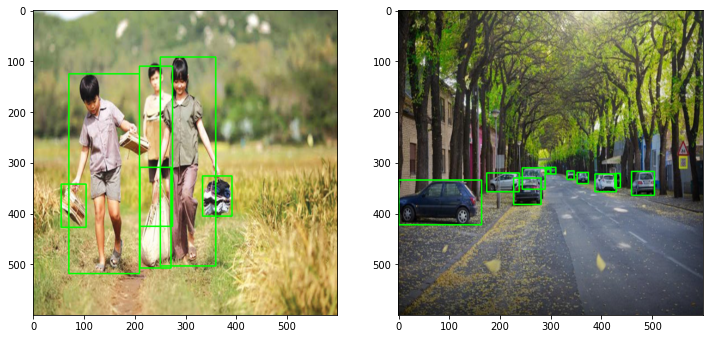

In [138]:
_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax, batch in zip(imgs, axs, detected):
    ax.imshow(draw_box(img, batch))
plt.show()